In [2]:

import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.utils import calc_total_error
import pandas as pd
from scipy.spatial import KDTree
import json


from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [3]:
%matplotlib inline

# Getting a cool aperuture one for poster

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_80966/3973917253.py:50: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


Galaxy: MESSIER 074


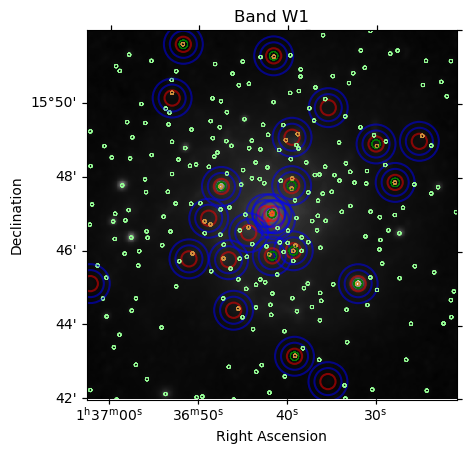

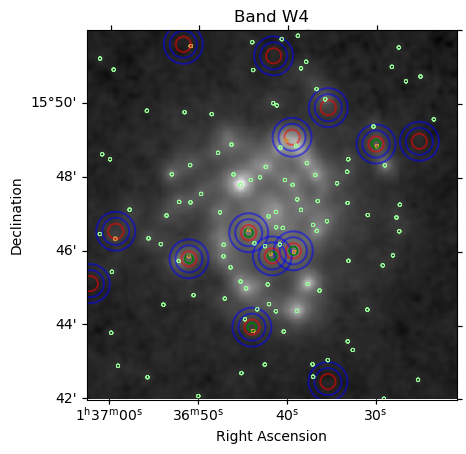

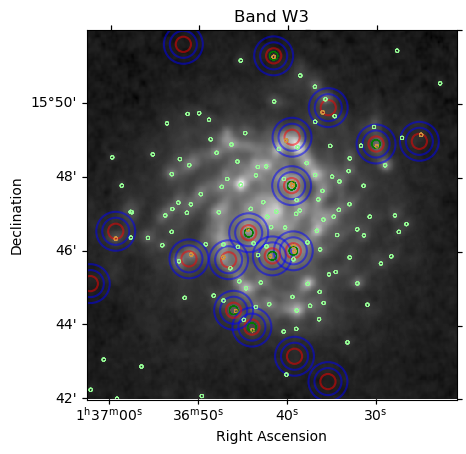

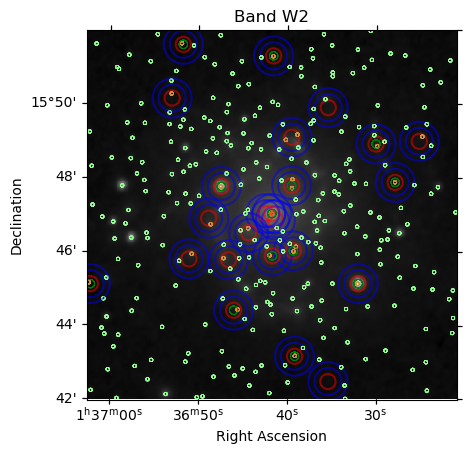

Number of valid sources:  80
Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once):  312
Number of sources coincidental with WISE bright points within 5 arcsec:  38


'\nprint("\n all of the valid sources")\ndisplay(display_data.loc[display_data[\'Flag\']== \'Valid\'])\nprint("\n all of the Yes!! sources")\ndisplay(display_data.loc[display_data[\'Exists?\']== \'Yes!!\'])\n\ndisplay(display_data)\nprint(len(display_data.loc[display_data[\'Flag\']== \'Valid\']))\n\n\n\n\n\n\n  \n#'

In [12]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask

def overlap_area(radius, distance):
    Area = ((2 * radius**2) * np.arccos((distance / (2 * radius)))) - ( .5 * distance * np.sqrt( (4 * radius**2) - distance**2))
    return Area



# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  



rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[21:22]



# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
#print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
    galaxy_name = galaxy.source_id
    #print(galaxy_name)
    #group = aligned_aggregatedsources.get_group(galaxy_name)
  
    # Print galaxy information
    #print(f"\nGalaxy: {galaxy_name}")
    #print(group)


    #define coordinates
    ra1 = galaxy.ra_x
    #print (ra1)
    dec1 = galaxy.dec_x
    pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
    #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
    im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
    #im_table
    im_table.to_table().colnames
    #print(im_table)
    # get the Ra and dec values necessary for the kdtree and rest of the code
    if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       #print("RA values:", ra)
       #print("Number of RA values:", len(ra))
    else:
       print(f"No sources found for galaxy: {galaxy_name}")
       continue # skip to the next galaxy if no sources were found
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1

    for i in [0, 3, 2, 1]:  # Reverse order index
        band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
        if band_id in band_labels:
            #print(f'Band {band_labels[band_id]}: ')
            data_url = im_table[i].getdataurl()
            #Download the image and open it in Astropy
            fname = download_file(data_url, cache=True)
            image1= fits.open(fname)
            image_data= image1[0].data
            #print(data)
            #print(data_url)
            wcs = WCS(image1[0].header)
            #cuting out the image of the galaxy apart from the rest of the background.
            cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
            wcs = cutout.wcs
            cutout_data = cutout.data
            #print(cutout_data)
            positions = wcs.world_to_pixel_values(ra, dec)
            positions = np.array(list(zip(positions[0], positions[1])))


            #define the distance threshold for the KDTree grouping (in pixels)
            distance_threshold = 5


            #build the KDTree for efficient grouping
            tree = KDTree(positions)


            #query the KDTree to find points within the defined radius of dist threshold and group them together
            groups = tree.query_ball_tree(tree, r=distance_threshold)
            # print(groups)
            # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
            unique_groups = []
            seen = set()
            for group in groups:
                group = tuple(sorted(group))
                if group not in seen:
                    seen.add(group)
                    unique_groups.append(group)
                 # print(unique_groups)
            # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
             #represents the consolidated postion of potentially multiple detections of one source.
            grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
            #print(grouped_positions)

            #print("Grouped positions for galaxy", galaxy_name, ":", grouped_positions)
            #define the Region(s) Of Interest (center x, center y, radius)
            ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping?
          


                # initialize valid rows plotting for the current image iteration
            valid_rows = []
           
           #now inputting the aperture photometry part
           # check for overlap and perform aperture photometry
            for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
                overlap_dict = []
                overlap = False # initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source. becomes true if they do overlap 
                acc_overlap = False # initialize the acceptable overlap flag.  false if there is no overlap, true if there is overlap and it is acceptable 
               

                for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                    if i != j: # ensures that a source is not compared to itself! wow
                        #print(f'{x}, {y} / {x2}, {y2}')
                        #print(f"Checking positions: ({x}, {y}) and ({x2, {y2}})")
                        distance = dist((x, y) , (x2, y2))
                        #print(f"Distance: {distance}, Radii Sum: {r + r2}")
                        #print('dsitance', distance)
                        #print('Distance', distance)
                        #print('r1', r)
                        if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                            #print(distance)
                            #print('yesif')
                            overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                            #print('overlap perc', overlap_percent)
                            if overlap_percent > .5:
                                overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                                #print('overlap is unacceptable: ', overlap)
                                overlap_aperture = np.nan
                                overlap_photo_table = np.nan
                                overlap_counts = np.nan
                                overlap_error = np.nan
                              
                            elif overlap_percent <= .5:
                                acc_overlap = True
                                #print('acceptable or no overlap: ', acc_overlap)
                                #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                                overlap_aperture = CircularAperture((x2, y2), r2)
                                overlapping_area = overlap_area(r,distance) # using the function to define the overlapping area for the location of overlap
                                overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                                total_area = math.pi * r**2
                                overlap_counts = overlap_photo_table['aperture_sum'][0] * ( overlapping_area/total_area ) # scaling the counts by the overlapping area
                                overlap_error = np.sqrt(overlap_counts)
                                overlap_dict.append({'Position': ({x}, {y}),  'overlapping counts': overlap_counts, 'overlap_error': overlap_error})
                                #print('were here')
                                #print('Overlap counts', overlap_counts)
                                #print('overlapdict', overlap_dict)



                        else:
                            #print(' Prob skips distance if statement')
                            #print('not overlapping at all')
                            overlap_percent = np.nan
                            overlap_aperture = np.nan
                            overlap_photo_table = np.nan
                            overlap_counts = np.nan
                            overlap_error = np.nan

                       
                #print(acc_overlap)  
                if acc_overlap:
                    overlap_counts = 0
                    overlap_error = 0
                    # for a source, if it overlaps with more than one other source, add all of the counts for those overlapping regions
                    for row in overlap_dict:
                        if not np.isnan(row['overlapping counts']) and not np.isnan(row['overlap_error']):
                            overlap_counts += row['overlapping counts'] # now add in quadriture for the propagation of error for sources like this
                            overlap_error += row['overlap_error']**2
                    overlap_error= np.sqrt(overlap_error)
                    #print('Overlapping COUNTS HERE', overlap_counts)
                    # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
                   
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]

                    target_counts -= overlap_counts
                    # so that i dont take the log or sqrt of a negative number or zero and get an error
                    if target_counts > 0: #
                        target_error= np.sqrt(target_counts)
                        #propagated error of overlap error
                        target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                        #print(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                          
                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:# to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        target_error = np.nan
                        target_overlap_counts_err = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                    # continuing on with the photometry under the "if acc_overlap"


                    #calculate area of target aperutue
                    target_area = target_aperture.area

                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                  
              
                    if annulus_counts > 0:
                        overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                        # to avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)




                    else: 
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        overlapannulus_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
              
                    #flag the sources that overlap
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all', 'Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]},  'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                       'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                  
                else: #perform all the normal aperture photometry stuff for those that do not overlap in any way.
            
                   # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
              
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]


                    if target_counts > 0:   # avoid taking the log of zero or negative value
                        target_error = np.sqrt(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:
                        target_error = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                      
                    #calculate area of target aperutue
                    target_area = target_aperture.area




                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                    # the error of the annulus for sources that overlap
                  
                    if annulus_counts > 0:
                        annulus_error = np.sqrt(annulus_counts)
                        # avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                    else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        annulus_error = np.nan
                        annulus_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                    if overlap:
                        overlap_counts = np.nan
                        overlap_error = np.nan
                        target_counts = np.nan

                    #   Append the result as a dictionary to the list named 'rows'
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all','Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
                        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
              
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                       'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                       'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                       'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })




            #Source detection code
            mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0) 
            #print((mean, median, std))


            # subtract the background and find FWHM of sources at a certain threshold
            #started at fwhm= 3 and threshold = 5
            daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background.
            sources = daofind(cutout_data - median) 
            #print(type(sources))
            # will likely run into iissues in the code below
            for col in sources.colnames: 
                if col not in ('id', 'npix'):
                    sources[col].info.format = '%.2f'  # for consistent table output
                        # sources.pprint(max_width=3000) 


                        #likely the flux labeled in this is not converted!
          
            # plot the image with marked locations of all the sources it detected.
            detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
            apertures = CircularAperture(detected_positions, r=2)




            # Plotting for current image
            # Filter valid rows
            valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
          
            # Was there a point source there?
            pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
            detectedpos_all = []
            #rows = [row for row in rows if row['Flag'] == 'Valid']
            for row in valid_rows_filtered:
                apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                for detected_position in detected_positions:
                    detected_x, detected_y = detected_position
                    distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                    if distance <= row['Radius']:
                        row['Exists?'] = 'Point Source Detected'
                        row['Point Source Position'].append((detected_x, detected_y))
                        dist_in_arc = distance * pixelsinarc
                        row['Offset in Arcseconds'].append((dist_in_arc))
                        detectedpos_all.append(detected_position)



            Yes = []
            YesRadius= 5
            for row in valid_rows_filtered:
                        apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                        for detected_position in detected_positions:
                            detected_x, detected_y = detected_position
                            distance = dist((row['X'], row['Y']), (detected_x, detected_y) )
                            if distance <= YesRadius:
                                row['Exists?'] = 'Yes!!'
                                Yes.append((row['X'], row['Y']))
                                #else: # this does not seem to do what i want it to do
                               #row['Exists?'] = 'Detected but does not exist'
                               
            #doing flux density
            for row in valid_rows_filtered:
                net_flx = row['Net Flux (Jy)']
                net_flx_err = row['Flux Uncertainty']
                wavelength = row['Wavelength']
                #print(net_flx)
                flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
                row['Flux Density'].append(flux_density)
                row['Flux Density Uncertainty'].append(flux_density_unc)
                  
          
            # Update rows with valid_rows_filtered information
            for valid_row in valid_rows_filtered:
                for row in rows:
                    if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                        row.update(valid_row)


            #print('valid sources', valid_rows_filtered)


            #print( len(detectedpos_all))
            if len(detectedpos_all) > 0:
                apertures_detected = CircularAperture(detectedpos_all, r=2)
            if len(Yes) > 0:
                apertures_Yes = CircularAperture(Yes, r=YesRadius)
          
         # xc = 244.422687    #19.014239
        # yc=  191.596758# 310.340772
      
                

           # Plotting for current image
            
            fig, ax = plt.subplots(subplot_kw={'projection': wcs})
            norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
            for row in valid_rows_filtered: # use 'valid_rows_filtered' to change it back to only the valid sources. use 'rows' to plot all sources
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
                annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
              
                apertures.plot(color='#98ff98', lw=.5, alpha=0.5)
                apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
                apertures_Yes.plot(color='green', lw=.5, alpha=0.5)


                # curious ones
            # curious = CircularAperture((xc,yc),5)
            # curious.plot(color='red', lw=.5, alpha=0.5)
            ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
            ax.set_xlabel('Right Ascension')
            ax.set_ylabel('Declination')
            plt.title(f'Band {band_labels[band_id]}')
            plt.show()
            yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
            #'''
   
           

  
  


           
      






display_data = pd.DataFrame(rows)
#by_name = display_data.groupby('Galaxy Name')
#byname = by_name.apply(lambda x: x).reset_index(drop=True)
#print("\n FINAL Sources Grouped by Galaxy:")
#display(byname)
#byname_byband = by_name.groupby('band_id')
#display(byname_byband)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)

print('Number of valid sources: ',len(display_data.loc[display_data['Flag']== 'Valid']))
print('Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once): ',len(display_data))
print('Number of sources coincidental with WISE bright points within 5 arcsec: ',len(display_data.loc[display_data['Exists?']== 'Yes!!']))
'''
print("\n all of the valid sources")
display(display_data.loc[display_data['Flag']== 'Valid'])
print("\n all of the Yes!! sources")
display(display_data.loc[display_data['Exists?']== 'Yes!!'])

display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))






  
#'''



# NGC 0253

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/1099872998.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 0253
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W3 Coadd 0116m258_ac51 ... 0116m258_ac51
W1 Coadd 0116m258_ac51 ... 0116m258_ac51
W2 Coadd 0116m258_ac51 ... 0116m258_ac51
W4 Coadd 0116m258_ac51 ... 0116m258_ac51
Galaxy: NGC 0253
RA values: [11.73603655 11.73990223 11.74763325 11.75096343 11.75213089 11.75580079
 11.77278556 11.77582518 11.77798277 11.77852457 11.77932921 11.7834114
 11.78778325 11.79019219 11.79268063 11.79619397 11.79934332 11.79989315
 11.80013286 11.80453486 11.81593482 11.81637361 11.82323245 11.82350189
 11.82469728 11.82632268 11.82709149 11.83204591 11.83428621 11.83666869
 11.83734764 11.83815896 11.84297149 11.84386272 11.84387761 11.84420826
 11.84646347 11.84652353 11.84794819 11.84795649 11.84952846 11.85170201
 11.8519429  11.85390531 11.85506342 11.85581141 11.

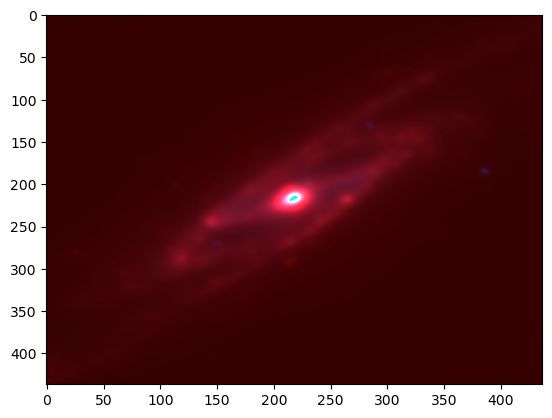

In [36]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[5:6]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave1norm = norm(rows[0]['data'])
wave2norm = norm(rows[2]['data'])
wave3norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2.5 # Adjust this factor as needed
wave1norm = np.clip(wave1norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave1norm  # Red channel
rgb_image[:, :, 1] = wave2norm  # Green channel
rgb_image[:, :, 2] = wave3norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# RGB code

In [ ]:
# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave1norm = norm(rows[0]['data'])
wave2norm = norm(rows[2]['data'])
wave3norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2 # Adjust this factor as needed
wave1norm = np.clip(wave1norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave1norm  # Red channel
rgb_image[:, :, 1] = wave2norm  # Green channel
rgb_image[:, :, 2] = wave3norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')







# for ngc 5128 

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/135922649.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 5128
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W4 Coadd 2022m425_ac51 ... 2022m425_ac51
W2 Coadd 2022m425_ac51 ... 2022m425_ac51
W1 Coadd 2022m425_ac51 ... 2022m425_ac51
W3 Coadd 2022m425_ac51 ... 2022m425_ac51
Galaxy: NGC 5128
RA values: [201.23369464 201.23657077 201.25128439 201.25416886 201.2610683
 201.26774089 201.26807596 201.26870325 201.26891047 201.27085808
 201.271053   201.27125626 201.27607209 201.27751756 201.2797316
 201.28065611 201.28167034 201.28392685 201.28742704 201.28818788
 201.28958782 201.29404139 201.29652584 201.29780373 201.29912637
 201.29988096 201.2999652  201.30128534 201.30361352 201.30796511
 201.30823944 201.30842718 201.31119065 201.31161746 201.31400316
 201.31528464 201.31563163 201.31557711 201.31668668 201.31790489
 201.31822799 201.31930379 201.31981

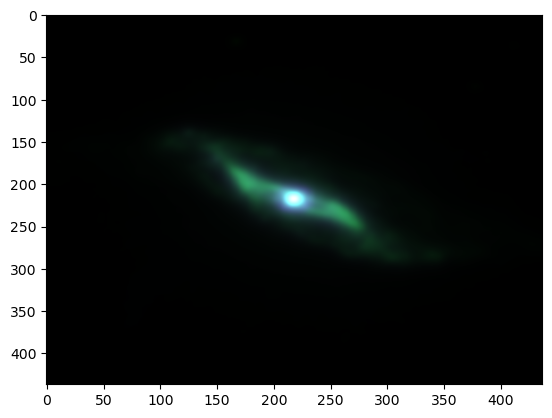

In [21]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[0:1]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave4norm = norm(rows[0]['data'])
wave3norm = norm(rows[1]['data'])
wave1norm = norm(rows[2]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2 # Adjust this factor as needed
wave1norm = np.clip(wave4norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave1norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave4norm  # Red channel
rgb_image[:, :, 1] = wave3norm  # Green channel
rgb_image[:, :, 2] = wave1norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# for messior 106 4, 3, 2

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_80966/3785898524.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
MESSIER 106
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W1 Coadd 1854p469_ac51 ... 1854p469_ac51
W2 Coadd 1854p469_ac51 ... 1854p469_ac51
W3 Coadd 1854p469_ac51 ... 1854p469_ac51
W4 Coadd 1854p469_ac51 ... 1854p469_ac51
Galaxy: MESSIER 106
RA values: [184.44460241 184.54385399 184.56603862 184.57094415 184.58294941
 184.60346585 184.60627749 184.66293183 184.66385229 184.67094524
 184.67583655 184.67827647 184.68067683 184.68082698 184.68106114
 184.6828655  184.68920892 184.69048342 184.69199044 184.69292664
 184.69701873 184.69726543 184.69866376 184.70193799 184.7021636
 184.70344418 184.70571616 184.70620251 184.70866803 184.71137883
 184.71518719 184.71531932 184.71980489 184.72060418 184.7229421
 184.7246959  184.72529573 184.72699844 184.72788489 184.72803568
 184.72916742 184.72993604 184

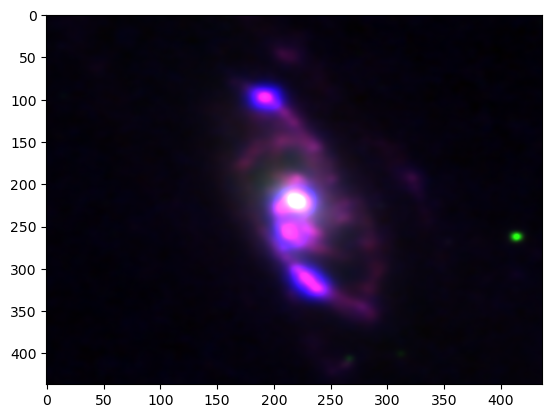

In [9]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[1:2]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave4norm = norm(rows[1]['data'])
wave2norm = norm(rows[2]['data'])
wave3norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 5.5 # Adjust this factor as needed
wave4norm = np.clip(wave4norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * 4, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave2norm  # Red channel
rgb_image[:, :, 1] = wave3norm  # Green channel
rgb_image[:, :, 2] = wave4norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# maybe 3,4,2 wavelength for NGC 2403

In [37]:
print(targetgals)

       ra_x   dec_x               source_id  cntr_01    dist_x      pang_x  \
0   201.365 -43.019                NGC 5128      1.0  0.830776  162.673944   
1   184.741  47.303             MESSIER 106      3.0  5.022737  -43.454463   
2   202.468  47.198             MESSIER 051      4.0  6.295556  -65.412743   
3   148.963  69.679             MESSIER 082      5.0  4.934001   60.594118   
4    67.704  64.848                NGC 1569      6.0  8.361842  -51.691199   
5    11.888 -25.288                NGC 0253      8.0  0.993958  158.563643   
6    35.639  42.349                NGC 0891     10.0  3.895011 -134.133495   
7    49.328 -41.106  NGC 1291:[LFF2012] 084     11.0  7.368795 -164.984930   
8   190.530  32.542                NGC 4631     12.0  9.053783   69.702218   
9   192.721  41.120             MESSIER 094     13.0  1.409980   58.249431   
10  196.365 -49.468                NGC 4945     14.0  1.444546  -95.506067   
11  172.005  78.993               UGC 06456     16.0  3.261849 -

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/4063241256.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 2403
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W3 Coadd 1153p651_ac51 ... 1153p651_ac51
W1 Coadd 1153p651_ac51 ... 1153p651_ac51
W2 Coadd 1153p651_ac51 ... 1153p651_ac51
W4 Coadd 1153p651_ac51 ... 1153p651_ac51
Galaxy: NGC 2403
RA values: [113.42853354 113.78878496 113.90955298 114.01729272 114.08794234
 114.10210664 114.10197033 114.10321367 114.10651401 114.10709121
 114.1075815  114.12485276 114.14236846 114.14806293 114.17501845
 114.17914878 114.18887523 114.19226021 114.19864532 114.20210239
 114.20864075 114.22419196 114.22438545 114.22560912 114.23053556
 114.23168362 114.23371408 114.23862677 114.24827268 114.25203557
 114.25333339 114.25965656 114.25980935 114.2610367  114.27682165
 114.27761019 114.27974154 114.28069117 114.2813892  114.2882372
 114.2912528  114.29248151 114.2983

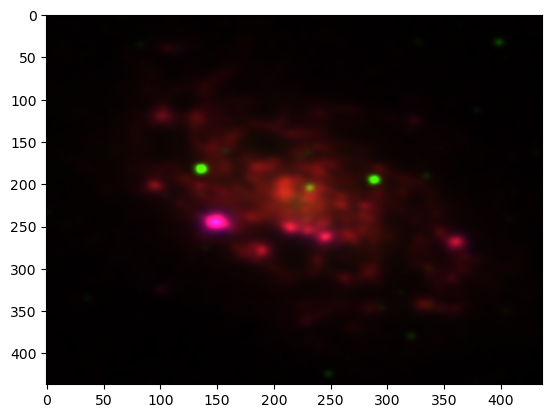

In [45]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[18:19]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave3norm = norm(rows[0]['data'])
wave4norm = norm(rows[1]['data'])
wave2norm = norm(rows[2]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2.5 # Adjust this factor as needed
wave1norm = np.clip(wave4norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave3norm  # Red channel
rgb_image[:, :, 1] = wave2norm  # Green channel
rgb_image[:, :, 2] = wave4norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# DEFINITELY : Messier 074!!! gorgeous : wavelengths 4,3,2

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/3249694503.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
MESSIER 074
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W1 Coadd 0234p151_ac51 ... 0234p151_ac51
W2 Coadd 0234p151_ac51 ... 0234p151_ac51
W3 Coadd 0234p151_ac51 ... 0234p151_ac51
W4 Coadd 0234p151_ac51 ... 0234p151_ac51
Galaxy: MESSIER 074
RA values: [24.06537622 24.08737816 24.09049838 24.10487072 24.11616443 24.12333281
 24.12362054 24.12519288 24.12588785 24.12682907 24.12897686 24.12982531
 24.13240991 24.13338313 24.1424332  24.14693459 24.14720696 24.14741829
 24.14768616 24.14903178 24.15699357 24.15712679 24.15803563 24.16265157
 24.16314301 24.16385828 24.16419035 24.16463062 24.16517241 24.16531472
 24.16708157 24.16886897 24.16936658 24.16964024 24.17229772 24.17339472
 24.17372508 24.17398566 24.17543814 24.17688432 24.18028298 24.18194514
 24.18293634 24.18296727 24.18318274 24.18372

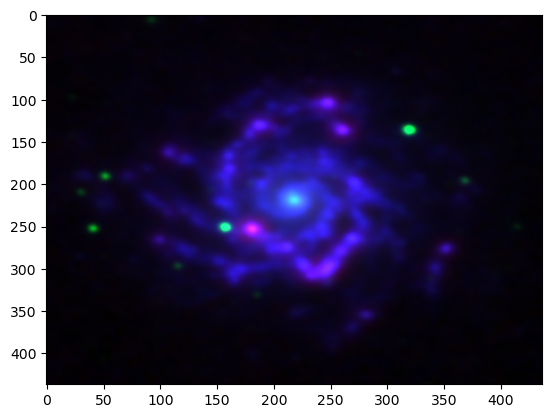

In [15]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[21:22]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave4norm = norm(rows[1]['data'])
wave3norm = norm(rows[2]['data'])
wave2norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2.5 # Adjust this factor as needed
wave1norm = np.clip(wave4norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave4norm  # Red channel
rgb_image[:, :, 1] = wave2norm  # Green channel
rgb_image[:, :, 2] = wave3norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# Messier 063 i think

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/1691202251.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
MESSIER 063
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W4 Coadd 1982p424_ac51 ... 1982p424_ac51
W1 Coadd 1982p424_ac51 ... 1982p424_ac51
W3 Coadd 1982p424_ac51 ... 1982p424_ac51
W2 Coadd 1982p424_ac51 ... 1982p424_ac51
Galaxy: MESSIER 063
RA values: [198.72862534 198.74580923 198.7637965  198.785626   198.82550292
 198.83155893 198.85380996 198.860847   198.86952105 198.87583245
 198.8764567  198.88940113 198.89169258 198.89678483 198.89721832
 198.9014068  198.90432561 198.90511664 198.90549752 198.90690745
 198.90725863 198.9139442  198.91460421 198.915502   198.91800546
 198.92021339 198.92519327 198.92784481 198.93065723 198.93277257
 198.9328109  198.93402039 198.93499341 198.935201   198.93703348
 198.93774857 198.940033   198.94022547 198.94202854 198.94263423
 198.94442237 198.94577676 1

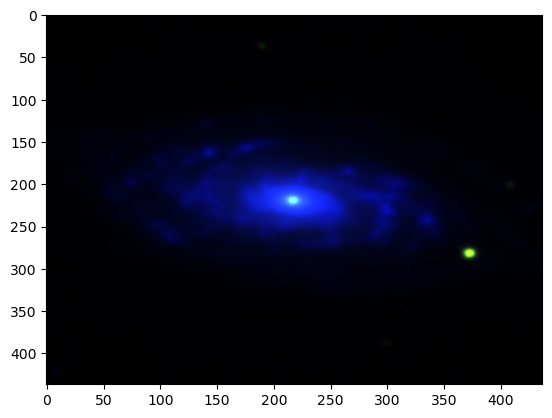

In [52]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[23:24]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave4norm = norm(rows[1]['data'])
wave3norm = norm(rows[2]['data'])
wave2norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 2.5 # Adjust this factor as needed
wave1norm = np.clip(wave4norm * brightness_factor, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * brightness_factor, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave4norm  # Red channel
rgb_image[:, :, 1] = wave2norm  # Green channel
rgb_image[:, :, 2] = wave3norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')


# NGC 4725 4, 3, 2

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_61942/4109955080.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 4725
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W1 Coadd 1933p257_ac51 ... 1933p257_ac51
W2 Coadd 1933p257_ac51 ... 1933p257_ac51
W3 Coadd 1933p257_ac51 ... 1933p257_ac51
W4 Coadd 1933p257_ac51 ... 1933p257_ac51
Galaxy: NGC 4725
RA values: [192.37691308 192.40178679 192.42076833 192.42503905 192.42888755
 192.44172306 192.44988298 192.47572882 192.47610674 192.48091177
 192.48087477 192.4827812  192.48380282 192.48489769 192.48501943
 192.49089695 192.49866542 192.5009889  192.50596253 192.51693538
 192.51971172 192.52138774 192.52375042 192.52434188 192.52672478
 192.5267401  192.53129425 192.53164976 192.53375398 192.54371055
 192.54376288 192.55104584 192.55107766 192.5515258  192.55159942
 192.55694246 192.5573606  192.56096729 192.56411753 192.56671303
 192.56863963 192.57283527 192.574

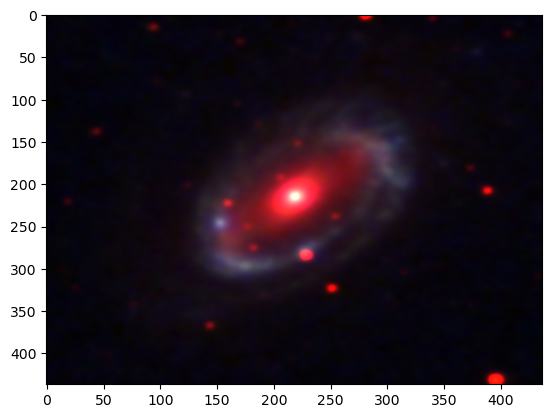

In [71]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[26:27]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data

           rows.append({'band_id': band_id, 'data': cutout_data})

# normalize the data
def norm(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Replace invalid values
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        return (data - data_min) / (data_max - data_min)
    else:
        return np.zeros_like(data)
# I want to use bands one two and three
wave4norm = norm(rows[1]['data'])
wave3norm = norm(rows[2]['data'])
wave2norm = norm(rows[3]['data'])

#complile into RGB image

#rgb_image = np.stack((wave1norm, wave2norm, wave3norm), axis= -1)


# Increase the brightness by scaling the normalized data
brightness_factor = 12 # Adjust this factor as needed
wave1norm = np.clip(wave4norm * 6, 0, 1)
wave2norm = np.clip(wave2norm * brightness_factor, 0, 1)
wave3norm = np.clip(wave3norm * 1.3, 0, 1)

# Create the RGB composite image
rgb_image = np.zeros((wave1norm.shape[0], wave1norm.shape[1], 3))
rgb_image[:, :, 0] = wave2norm  # Red channel
rgb_image[:, :, 1] = wave3norm  # Green channel
rgb_image[:, :, 2] = wave4norm  # Blue channel


#ax.axis('off')  # Hide axis
plt.imshow(rgb_image, aspect='auto')
